# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [3]:
 !pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 2.1 MB/s eta 0:00:00


In [4]:
import FinanceDataReader as fdr

In [5]:
# 세명전기 (017510) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('017510')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [7]:
samsung.tail(20)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-06-04,4650,4650,4350,4375,972350,-0.058127
2024-06-05,4415,4415,4250,4365,420420,-0.002286
2024-06-07,4385,4430,4305,4330,363393,-0.008018
2024-06-10,4330,5620,4240,5620,14935997,0.297921
2024-06-11,5840,6390,5530,5650,25983397,0.005338
2024-06-12,6010,6250,5610,5740,15752835,0.015929
2024-06-13,5890,6150,5570,5640,3840835,-0.017422
2024-06-14,5580,5620,5240,5350,1239144,-0.051418
2024-06-17,5390,5410,5100,5180,851337,-0.031776


**미국 주식 데이터**도 가져올 수 있습니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [9]:
apple.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-25,209.149994,211.380005,208.610001,209.070007,209.070007,56713900
2024-06-26,211.500000,214.860001,210.639999,213.250000,213.250000,66213200
2024-06-27,214.690002,215.740005,212.350006,214.100006,214.100006,49772700
2024-06-28,215.770004,216.070007,210.300003,210.619995,210.619995,82475600
2024-07-01,212.130005,214.039993,211.919998,212.750000,212.750000,6449814


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [9]:
# Apple(AAPL), 애플
apple = fdr.DataReader('NVDA', '2024')

In [11]:
apple.head(20)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,49.243999,49.294998,47.595001,48.167999,48.161785,411254000
2024-01-03,47.485001,48.183998,47.320000,47.569000,47.562862,320896000
2024-01-04,47.766998,48.500000,47.507999,47.998001,47.991810,306535000
2024-01-05,48.462002,49.547001,48.306000,49.097000,49.090664,415039000
2024-01-08,49.512001,52.275002,49.479000,52.252998,52.246258,642510000
2024-01-09,52.401001,54.325001,51.689999,53.139999,53.133144,773100000
2024-01-10,53.616001,54.599998,53.488998,54.349998,54.342987,533796000
2024-01-11,54.999001,55.346001,53.560001,54.821999,54.814926,596759000
2024-01-12,54.619999,54.970001,54.330002,54.709999,54.702938,352994000


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [14]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1990-01-01', '2024-12-30')

In [15]:
ford.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,7.983336,8.257051,7.937717,8.257051,2.339106,6241908
1990-01-03,8.302670,8.371098,8.257051,8.302670,2.352030,8032278
1990-01-04,8.325479,8.348289,8.234241,8.302670,2.352030,3932566
1990-01-05,8.302670,8.348289,8.188622,8.188622,2.319722,3820771
1990-01-08,8.165813,8.211432,8.120194,8.188622,2.319722,3360985


In [16]:
ford.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-25,12.17,12.21,12.03,12.09,12.09,39323900
2024-06-26,12.01,12.13,11.95,12.11,12.11,41426600
2024-06-27,12.08,12.38,12.05,12.23,12.23,48080200
2024-06-28,12.26,12.62,12.26,12.54,12.54,65914700
2024-07-01,12.56,12.87,12.53,12.76,12.76,56124900


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [ ]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니,

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [18]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '017510'

In [19]:
stock = fdr.DataReader(STOCK_CODE)

In [20]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-03-10,3830,4150,3600,3800,525324,NaN
2000-03-13,3820,4250,3820,4250,828727,0.118421
2000-03-14,4350,4760,4250,4760,1918721,0.120000
2000-03-15,4760,5330,4250,4250,2785930,-0.107143
2000-03-16,4290,4440,3740,3740,1149324,-0.120000


In [21]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-06-26,7160,7740,7020,7290,17495736,0.029661
2024-06-27,7230,9400,7180,9010,36926179,0.235940
2024-06-28,8800,9090,8530,8830,5186900,-0.019978
2024-07-01,8900,8910,8060,8060,2567379,-0.087203
2024-07-02,8060,8600,7710,7860,4378292,-0.024814


In [22]:
stock.index

DatetimeIndex(['2000-03-10', '2000-03-13', '2000-03-14', '2000-03-15',
               '2000-03-16', '2000-03-17', '2000-03-20', '2000-03-21',
               '2000-03-22', '2000-03-23',
               ...
               '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-24',
               '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28',
               '2024-07-01', '2024-07-02'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [23]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [24]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2000-03-10,3830,4150,3600,3800,525324,NaN,2000,3,10
2000-03-13,3820,4250,3820,4250,828727,0.118421,2000,3,13
2000-03-14,4350,4760,4250,4760,1918721,0.120000,2000,3,14
2000-03-15,4760,5330,4250,4250,2785930,-0.107143,2000,3,15
2000-03-16,4290,4440,3740,3740,1149324,-0.120000,2000,3,16


## 시각화

Text(0, 0.5, 'price')

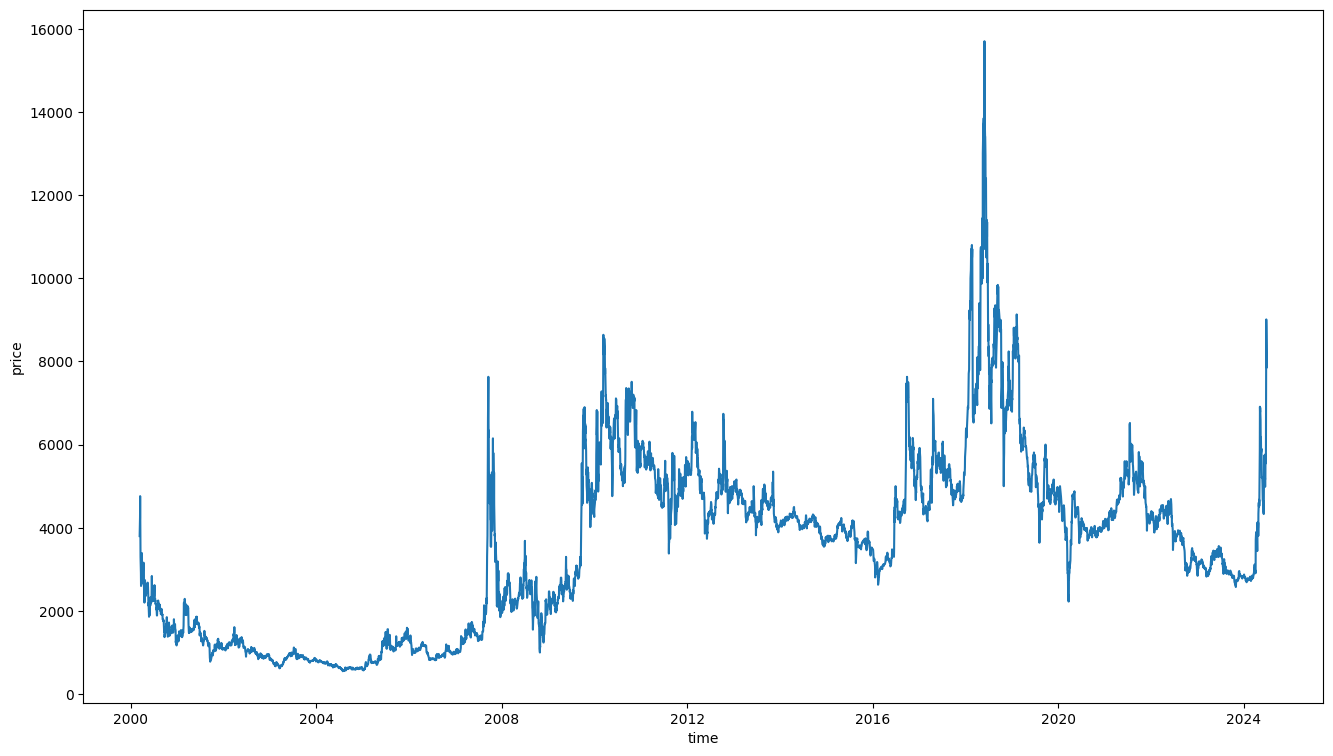

In [25]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

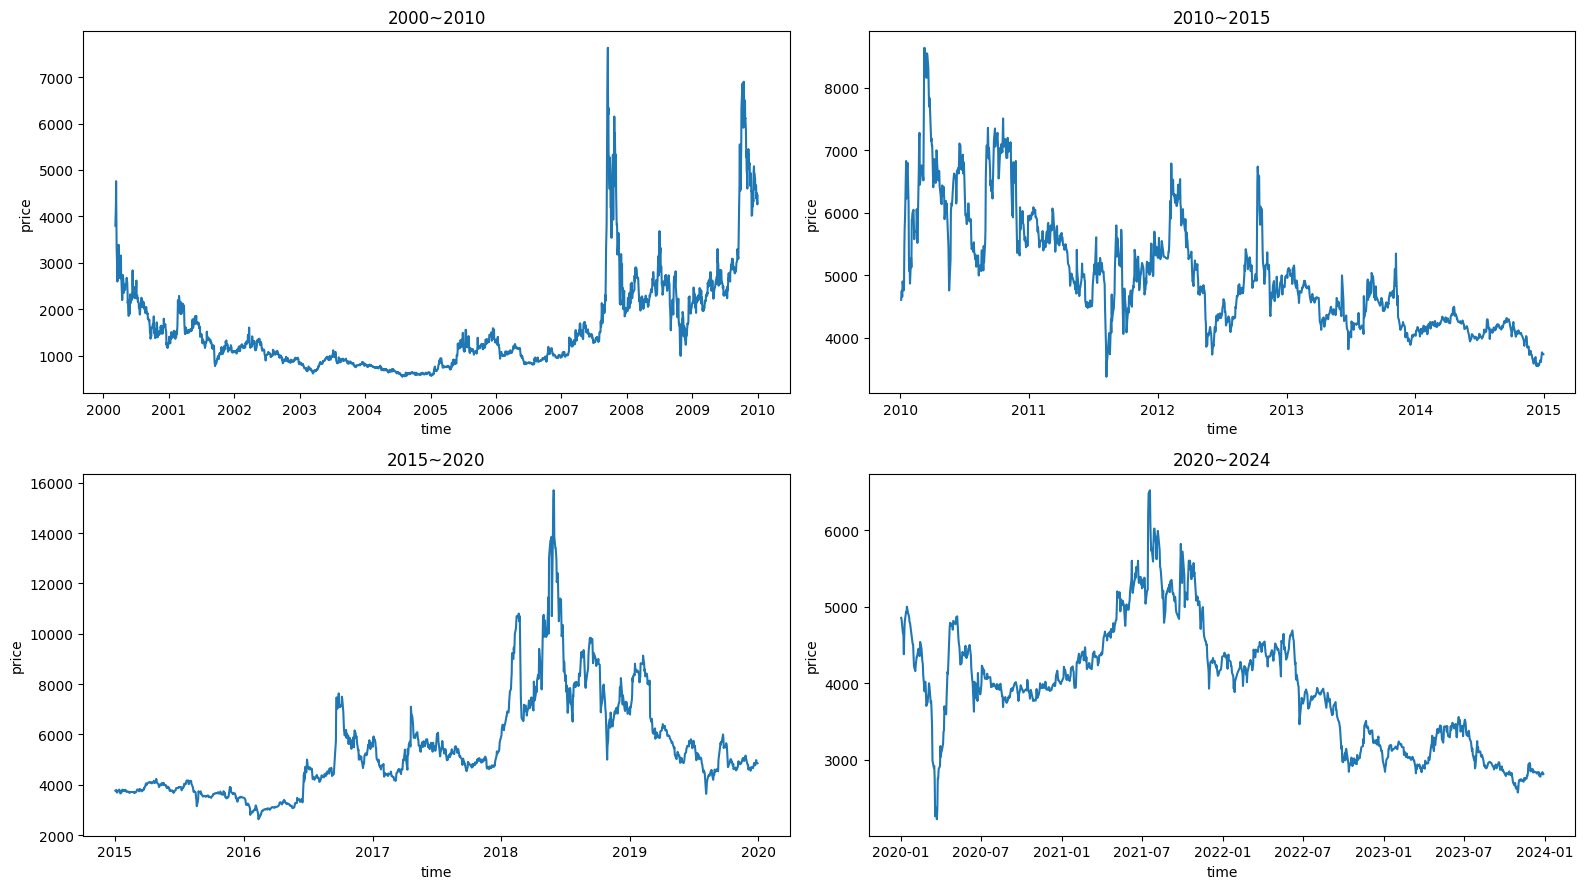

In [26]:
time_steps = [
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2020'],
              ['2020', '2024']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.20958466, 0.22218779, 0.20882852, 0.21452145, 0.01422633],
       [0.20894569, 0.2283855 , 0.2237691 , 0.24422442, 0.0224428 ],
       [0.2428115 , 0.2599938 , 0.25297114, 0.27788779, 0.05196099],
       ...,
       [0.52715655, 0.52835451, 0.54363328, 0.54653465, 0.14046674],
       [0.53354633, 0.51719864, 0.51171477, 0.49570957, 0.06952734],
       [0.4798722 , 0.49798575, 0.48794567, 0.48250825, 0.11856878]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [35]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1),
                                                    df['Close'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=False)

In [32]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [33]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [34]:
x_train

,Open,High,Low,Volume
0,0.209585,0.222188,0.208829,0.014226
1,0.208946,0.228385,0.223769,0.022443
2,0.242812,0.259994,0.252971,0.051961
3,0.269010,0.295321,0.252971,0.075446
4,0.238978,0.240161,0.218336,0.031125
...,...,...,...,...
4795,0.235144,0.237062,0.250255,0.002242
4796,0.237700,0.235823,0.254329,0.001068
4797,0.247284,0.244500,0.262139,0.001085
4798,0.246006,0.240161,0.248217,0.001267


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [37]:
import tensorflow as tf

In [38]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [39]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [40]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [41]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [43]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [44]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [45]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 7s 7ms/step - loss: 8.7535e-04 - mse: 0.0018
Epoch 1: val_loss improved from inf to 0.00026, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 8s 13ms/step - loss: 8.7535e-04 - mse: 0.0018 - val_loss: 2.5749e-04 - val_mse: 5.1497e-04
Epoch 2/50
145/150 [============================>.] - ETA: 0s - loss: 3.5549e-04 - mse: 7.1097e-04
Epoch 2: val_loss improved from 0.00026 to 0.00022, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 13ms/step - loss: 3.7054e-04 - mse: 7.4107e-04 - val_loss: 2.2284e-04 - val_mse: 4.4567e-04
Epoch 3/50
145/150 [============================>.] - ETA: 0s - loss: 2.8767e-04 - mse: 5.7534e-04
Epoch 3: val_loss improved from 0.00022 to 0.00018, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 13ms/step - loss: 2.9975e-04 - mse: 5.9950e-04 - val_loss: 1.8164e-04 - val_mse: 3.6329e-04
Epoch 4/50
144/150 [===========================>..] 

#RNN

In [1]:
#setup

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164106 (641.04 KB)
Trainable params: 164106 (641.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361866 (1.38 MB)
Trainable params: 361866 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 64)             64000     ['input_1[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, None, 64)             128000    ['input_2[0][0]']             
                                                                                              

In [5]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru_1 (GRU)                 (None, None, 256)         247296    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361866 (1.38 MB)
Trainable params: 361866 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, None, 64)             64000     ['input_3[0][0]']             
                                                                                                  
 embedding_6 (Embedding)     (None, None, 64)             128000    ['input_4[0][0]']             
                                                                                            

#교차검증
- 시퀀스 s = [t0, t1, ... t1546, t1547]의 경우 다음과 같이 분할
- s1 = [t0, t1, ... t100]
- s2 = [t101, ... t201]
- ...
- s16 = [t1501, ... t1547]

In [ ]:
#교차검증

lstm_layer = layers.LSTM(64, stateful=True)

for s in sub_sequences:
  output = lstm_layer(s)

In [ ]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()

저장한 ModelCheckpoint 를 로드합니다.

In [47]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [48]:
pred = model.predict(test_data)

37/37 [==============================] - 0s 4ms/step


In [ ]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

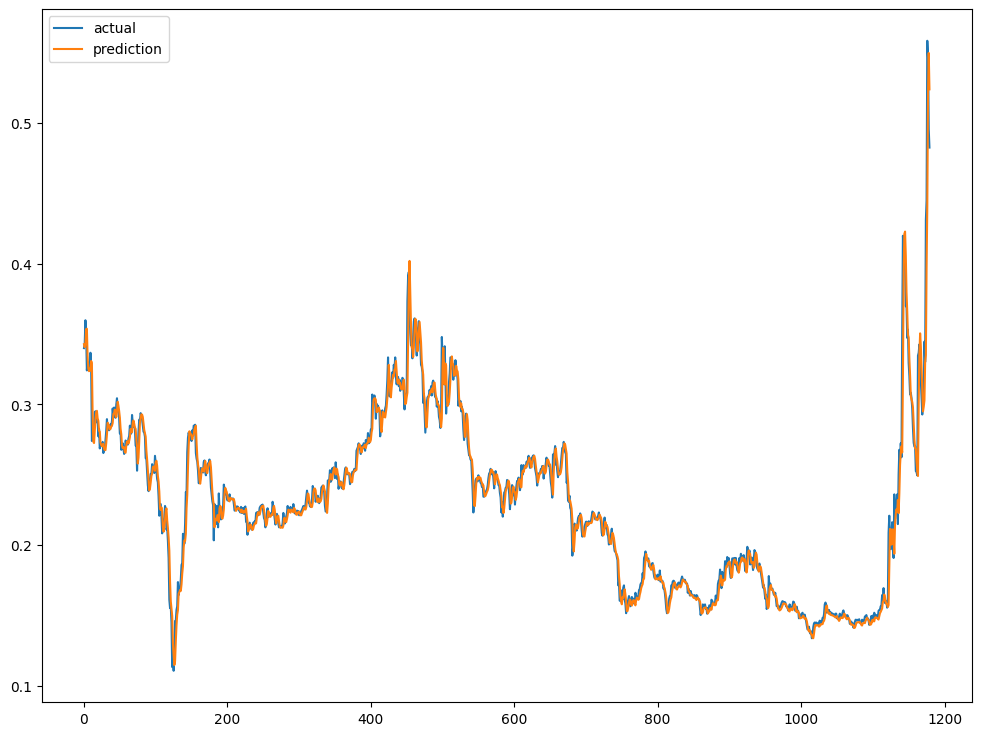

In [49]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()